# Install Dependencies

In [10]:
!pip install -q kaggle

# Import Dependencies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from google.colab import drive
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mohamedhisham20/shoplifting-dataset-2-0-4-labels
!unzip shoplifting-dataset-2-0-4-labels.zip

Dataset URL: https://www.kaggle.com/datasets/mohamedhisham20/shoplifting-dataset-2-0-4-labels
License(s): other
100% 902M/906M [00:07<00:00, 122MB/s]
100% 906M/906M [00:07<00:00, 125MB/s]
Archive:  shoplifting-dataset-2-0-4-labels.zip
  inflating: Shoplifting Dataset/normal/shop_lifter_n_1.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_102.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_103.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_107.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_108.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_11.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_112.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_113.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_119.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_122.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_124.mp4  
  inflating: Shoplifting Dataset/normal/shop_lifter_n_128.mp4  


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [4]:
def save_directories_to_drive(source_path, dest_drive, dir_names):
    # Create the main folder in the destination
    main_folder = os.path.join(dest_drive, 'Shoplifting')
    os.makedirs(main_folder, exist_ok=True)

    for dir_name in dir_names:
        source_dir = os.path.join(source_path, dir_name)
        dest_dir = os.path.join(main_folder, dir_name)

        # Copy the directory to the destination
        if os.path.exists(source_dir):
            shutil.copytree(source_dir, dest_dir)
            print(f"Copied {dir_name} to {dest_dir}")
        else:
            print(f"Directory {dir_name} not found in source path.")

In [17]:
source_path = '/content/Shoplifting Dataset'
dest_drive = '/content/drive/MyDrive'
dir_names = ['shoplifting', 'normal']

save_directories_to_drive(source_path, dest_drive, dir_names)

Copied shoplifting to /content/drive/MyDrive/Shoplifting/shoplifting
Copied normal to /content/drive/MyDrive/Shoplifting/normal


In [12]:
def extract_frames(video_path, output_dir, num_frames):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval for frame extraction
    interval = total_frames // num_frames

    frame_count = 0
    for i in range(total_frames):
        ret, frame = cap.read()
        if ret and (i % interval == 0) and (frame_count < num_frames):
            filename = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(video_path))[0]}_frame_{frame_count}.jpg")
            cv2.imwrite(filename, frame)
            frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames from {video_path} to {output_dir}")

In [13]:
def process_video_folder(video_folder, output_base_dir, num_frames):
    os.makedirs(output_base_dir, exist_ok=True)  # Ensure the output directory exists
    for video_file in os.listdir(video_folder):
        if video_file.endswith('.mp4'):
            video_path = os.path.join(video_folder, video_file)
            extract_frames(video_path, output_base_dir, num_frames)

In [15]:
def delete_videos(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.mp4'):
            file_path = os.path.join(folder_path, filename)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

In [18]:
normal_folder_path = '/content/drive/MyDrive/Shoplifting/normal'
output_path = '/content/drive/MyDrive/Shoplifting/normal'
process_video_folder(normal_folder_path, output_path, 30)
delete_videos(normal_folder_path)

Extracted 30 frames from /content/drive/MyDrive/Shoplifting/normal/shop_lifter_n_108.mp4 to /content/drive/MyDrive/Shoplifting/normal
Extracted 30 frames from /content/drive/MyDrive/Shoplifting/normal/shop_lifter_n_162.mp4 to /content/drive/MyDrive/Shoplifting/normal
Extracted 30 frames from /content/drive/MyDrive/Shoplifting/normal/shop_lifter_n_23.mp4 to /content/drive/MyDrive/Shoplifting/normal
Extracted 30 frames from /content/drive/MyDrive/Shoplifting/normal/shop_lifter_n_146.mp4 to /content/drive/MyDrive/Shoplifting/normal
Extracted 30 frames from /content/drive/MyDrive/Shoplifting/normal/shop_lifter_n_68.mp4 to /content/drive/MyDrive/Shoplifting/normal
Extracted 30 frames from /content/drive/MyDrive/Shoplifting/normal/shop_lifter_n_33.mp4 to /content/drive/MyDrive/Shoplifting/normal
Extracted 30 frames from /content/drive/MyDrive/Shoplifting/normal/shop_lifter_n_193.mp4 to /content/drive/MyDrive/Shoplifting/normal
Extracted 30 frames from /content/drive/MyDrive/Shoplifting/norma

In [19]:
shoplifting_folder_path = '/content/drive/MyDrive/Shoplifting/shoplifting'
output_path = '/content/drive/MyDrive/Shoplifting/shoplifting'
process_video_folder(shoplifting_folder_path, output_path, 22)
delete_videos(shoplifting_folder_path)

Extracted 22 frames from /content/drive/MyDrive/Shoplifting/shoplifting/shop_lifter_9.mp4 to /content/drive/MyDrive/Shoplifting/shoplifting
Extracted 22 frames from /content/drive/MyDrive/Shoplifting/shoplifting/shop_lifter_7.mp4 to /content/drive/MyDrive/Shoplifting/shoplifting
Extracted 22 frames from /content/drive/MyDrive/Shoplifting/shoplifting/shop_lifter_14.mp4 to /content/drive/MyDrive/Shoplifting/shoplifting
Extracted 22 frames from /content/drive/MyDrive/Shoplifting/shoplifting/shop_lifter_62.mp4 to /content/drive/MyDrive/Shoplifting/shoplifting
Extracted 22 frames from /content/drive/MyDrive/Shoplifting/shoplifting/shop_lifter_37.mp4 to /content/drive/MyDrive/Shoplifting/shoplifting
Extracted 22 frames from /content/drive/MyDrive/Shoplifting/shoplifting/shop_lifter_28.mp4 to /content/drive/MyDrive/Shoplifting/shoplifting
Extracted 22 frames from /content/drive/MyDrive/Shoplifting/shoplifting/shop_lifter_96.mp4 to /content/drive/MyDrive/Shoplifting/shoplifting
Extracted 22 fr

In [20]:
data_dir = '/content/drive/MyDrive/Shoplifting'

In [16]:
# Remove the '.ipynb_checkpoints' directory
checkpoint_dir = os.path.join(data_dir, '.ipynb_checkpoints')
if os.path.exists(checkpoint_dir):
  shutil.rmtree(checkpoint_dir)
  print("Removed '.ipynb_checkpoints' directory.")
else:
  print("'.ipynb_checkpoints' directory not found.")


Removed '.ipynb_checkpoints' directory.


In [21]:
os.listdir(data_dir)

['shoplifting', 'normal']

In [22]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 4948 files belonging to 2 classes.


In [24]:
def count_frames(directory):
  count = 0
  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith('.jpg'):
        count += 1
  return count

normal_frames_dir = '/content/drive/MyDrive/Shoplifting/normal'
shoplifting_frames_dir = '/content/drive/MyDrive/Shoplifting/shoplifting'

normal_count = count_frames(normal_frames_dir)
shoplifting_count = count_frames(shoplifting_frames_dir)

print("Number of normal frames:", normal_count)
print("Number of shoplifting frames:", shoplifting_count)


Number of normal frames: 2550
Number of shoplifting frames: 2398


In [26]:
def split_data(input_dir, output_dir, test_size=0.2):
    # Ensure the output directories exist
    os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

    # Define classes
    classes = ['normal', 'shoplifting']

    for cls in classes:
        class_dir = os.path.join(input_dir, cls)
        images = os.listdir(class_dir)

        # Split images into train and test sets
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        # Create class-specific directories in train and test folders
        train_class_dir = os.path.join(output_dir, 'train', cls)
        test_class_dir = os.path.join(output_dir, 'test', cls)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Copy files to the train directory
        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_class_dir, image)
            shutil.copyfile(src, dst)

        # Copy files to the test directory
        for image in test_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(test_class_dir, image)
            shutil.copyfile(src, dst)

    print("Train-test split completed.")

In [27]:
input_directory = '/content/drive/MyDrive/Shoplifting'
output_directory = '/content/drive/MyDrive/Shoplifting'
split_data(input_directory, output_directory)

Train-test split completed.


In [33]:
# Delete 'normal' and 'shoplifting' folders within 'Shoplifting'
for folder_name in ['normal', 'shoplifting']:
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder not found: {folder_path}")


Deleted folder: /content/drive/MyDrive/Shoplifting/normal
Deleted folder: /content/drive/MyDrive/Shoplifting/shoplifting


In [4]:
def count_frames_in_split(directory):
  total_count = 0
  normal_count = 0
  shoplifting_count = 0

  for root, dirs, files in os.walk(directory):
    for file in files:
      if file.endswith('.jpg'):
        total_count += 1
        if 'normal' in root:
          normal_count += 1
        elif 'shoplifting' in root:
          shoplifting_count += 1

  return total_count, normal_count, shoplifting_count

train_dir = '/content/drive/MyDrive/Shoplifting/train'
test_dir = '/content/drive/MyDrive/Shoplifting/test'

train_total, train_normal, train_shoplifting = count_frames_in_split(train_dir)
test_total, test_normal, test_shoplifting = count_frames_in_split(test_dir)

print("Train set:")
print("Total frames:", train_total)
print("Normal frames:", train_normal)
print("Shoplifting frames:", train_shoplifting)
print("\nTest set:")
print("Total frames:", test_total)
print("Normal frames:", test_normal)
print("Shoplifting frames:", test_shoplifting)


Train set:
Total frames: 3958
Normal frames: 2040
Shoplifting frames: 1918

Test set:
Total frames: 990
Normal frames: 510
Shoplifting frames: 480


In [5]:
def load_images_from_folder(folder, num_images):
    images = []
    filenames = os.listdir(folder)
    random.shuffle(filenames)  # Shuffle to get random images
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
        if len(images) >= num_images:
            break
    return images

In [6]:
def show_random_images(directories, num_images_per_class):
    fig, ax = plt.subplots(nrows=len(directories), ncols=num_images_per_class, figsize=(15, len(directories) * 5))

    for i, (folder, label) in enumerate(directories):
        images = load_images_from_folder(folder, num_images_per_class)

        for j, img in enumerate(images):
            ax[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
            ax[i, j].title.set_text(label)
            ax[i, j].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

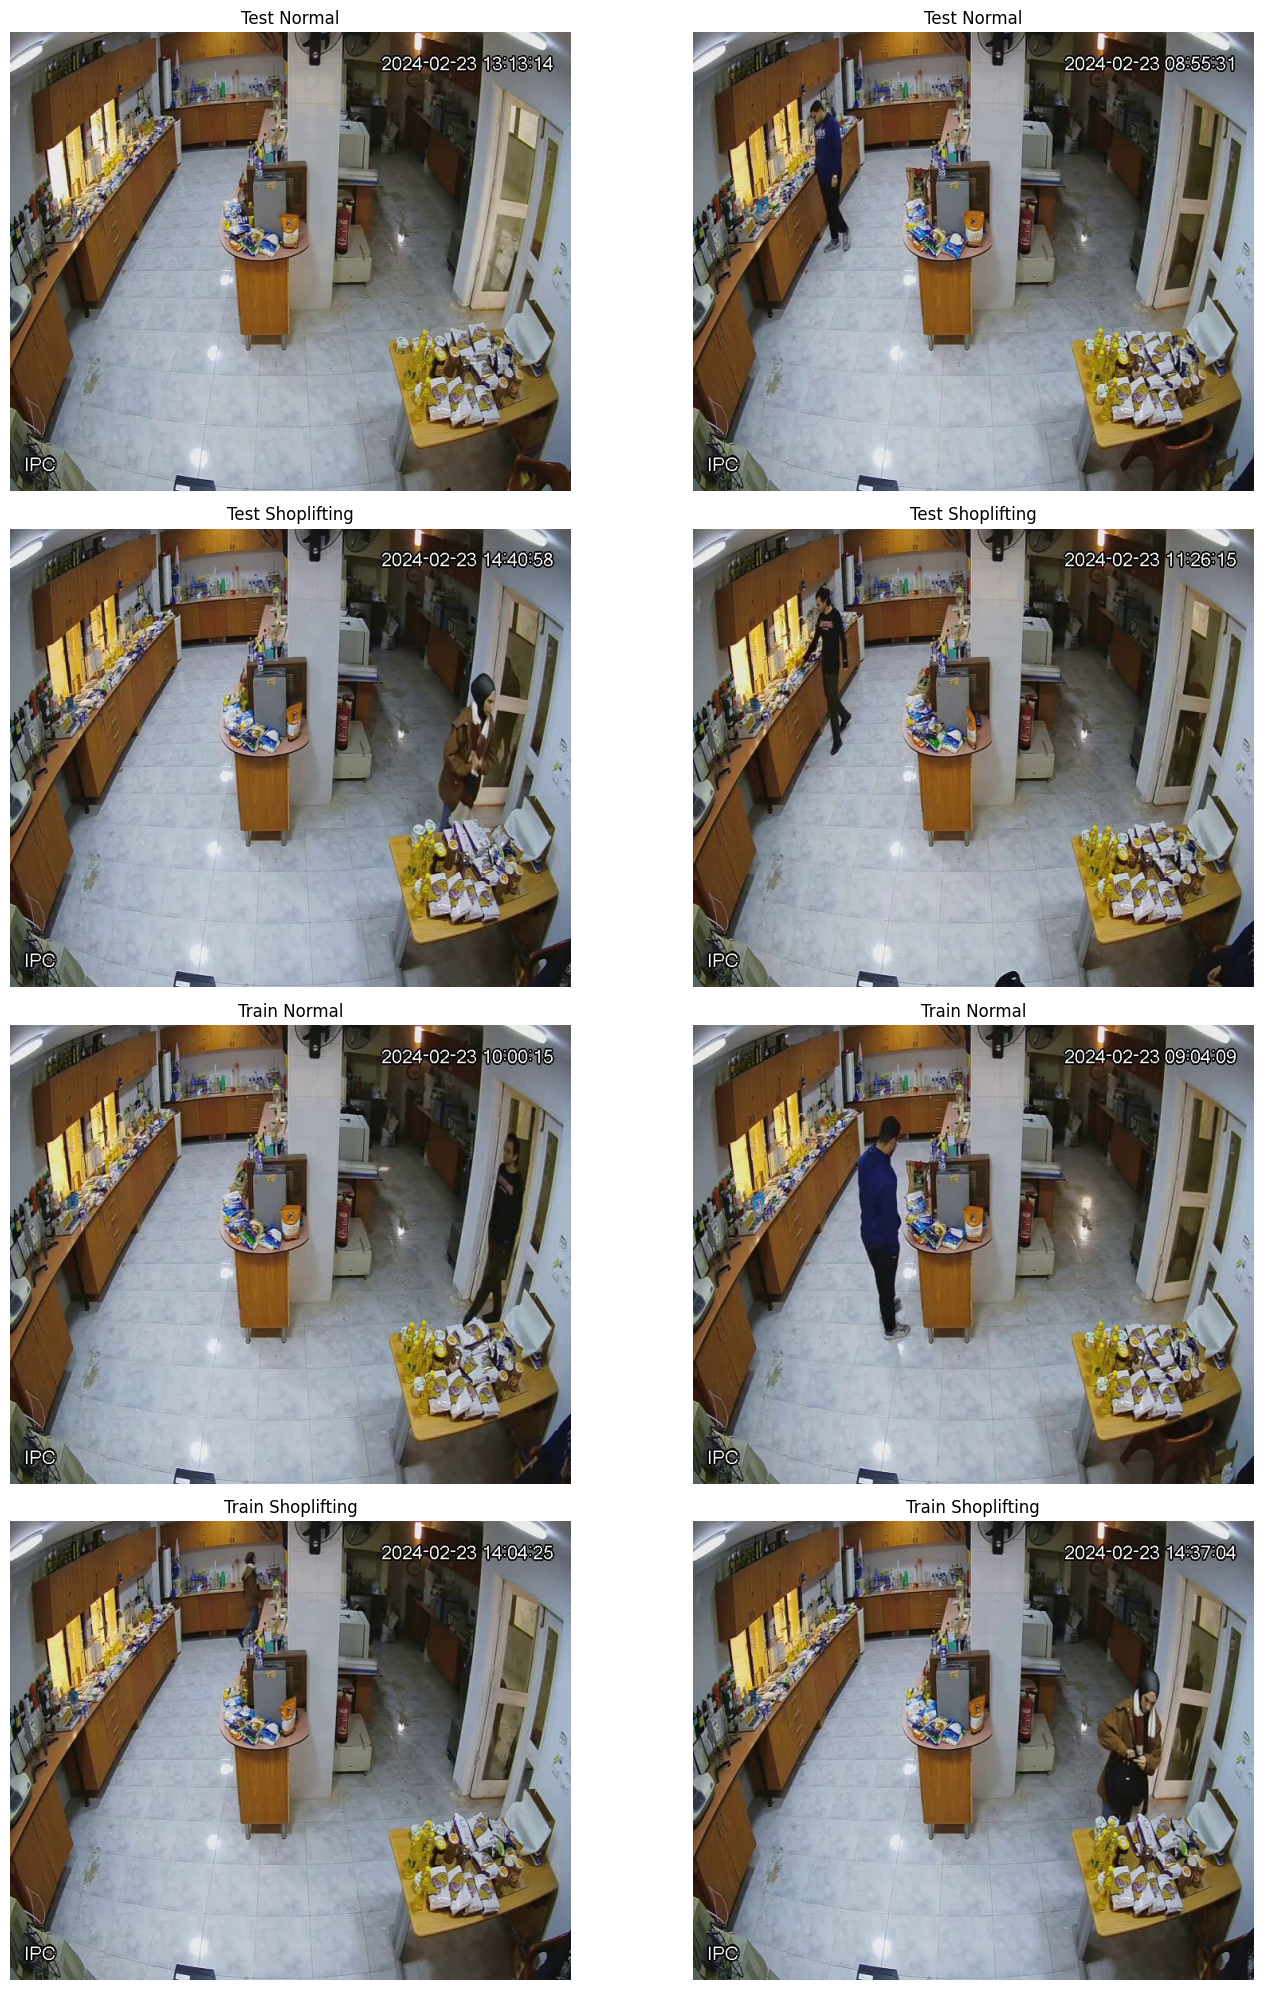

In [7]:
# Directories for normal and shoplifting images
test_normal_dir = '/content/drive/MyDrive/Shoplifting/test/normal'
test_shoplifting_dir = '/content/drive/MyDrive/Shoplifting/test/shoplifting'
train_normal_dir = '/content/drive/MyDrive/Shoplifting/train/normal'
train_shoplifting_dir = '/content/drive/MyDrive/Shoplifting/train/shoplifting'

# Folders to display images from
directories = [
    (test_normal_dir, 'Test Normal'),
    (test_shoplifting_dir, 'Test Shoplifting'),
    (train_normal_dir, 'Train Normal'),
    (train_shoplifting_dir, 'Train Shoplifting')
]

show_random_images(directories, num_images_per_class=2)

# Data Augmentation By ImageDataGenerator

In [2]:
# Data Augmentation Parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0, 1]
    rotation_range=40,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    zoom_range=0.2,  # Randomly zoom into images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in newly created pixels after transformations
)

test_datagen = ImageDataGenerator(
    rescale=1./255  # Only rescale images for test set
)

In [3]:
# Creating data generators
train_generator = train_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Shoplifting/train',
    target_size=(224, 224),  # Resize images to match model input size
    batch_size=32,
    class_mode='binary'  # Use 'binary' for binary classification (normal vs shoplifting)
)

test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/Shoplifting/test',
    target_size=(224, 224),  # Resize images to match model input size
    batch_size=32,
    class_mode='binary'  # Use 'binary' for binary classification
)

Found 3958 images belonging to 2 classes.
Found 990 images belonging to 2 classes.


In [4]:
# Check a batch of augmented images
def show_augmented_images(generator, num_images=4):
    batch = next(generator)
    images, labels = batch
    fig, ax = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        ax[i].imshow(images[i])
        ax[i].title.set_text('Label: {}'.format('Shoplifting' if labels[i] == 1 else 'Normal'))
        ax[i].axis('off')
    plt.show()

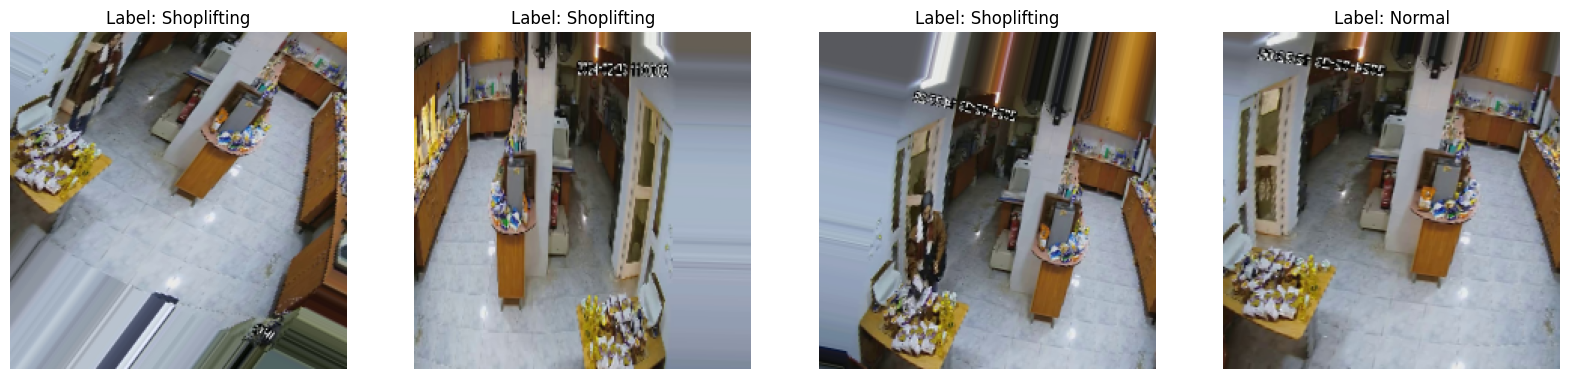

In [5]:
# Display a batch of augmented training images
show_augmented_images(train_generator)

In [6]:
# Load the pre-trained ResNet101 model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's weights
base_model.trainable = False

In [7]:
# Add a new classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [8]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)

# Train the model
history = model.fit(train_generator, epochs=100, callbacks=early_stopping, validation_data=test_generator)

Epoch 1/100
124/124 [==============================] - 1406s 11s/step - loss: 0.7387 - accuracy: 0.5078 - val_loss: 0.6921 - val_accuracy: 0.5152
Epoch 2/100
124/124 [==============================] - 89s 722ms/step - loss: 0.7074 - accuracy: 0.5099 - val_loss: 0.6882 - val_accuracy: 0.5152
Epoch 3/100
124/124 [==============================] - 89s 721ms/step - loss: 0.6982 - accuracy: 0.5328 - val_loss: 0.6979 - val_accuracy: 0.5152
Epoch 4/100
124/124 [==============================] - 88s 707ms/step - loss: 0.6956 - accuracy: 0.5179 - val_loss: 0.6866 - val_accuracy: 0.5495
Epoch 5/100
124/124 [==============================] - 87s 706ms/step - loss: 0.7038 - accuracy: 0.5237 - val_loss: 0.7124 - val_accuracy: 0.5152
Epoch 6/100
124/124 [==============================] - 89s 715ms/step - loss: 0.6915 - accuracy: 0.5202 - val_loss: 0.6843 - val_accuracy: 0.5152
Epoch 7/100
124/124 [==============================] - 87s 700ms/step - loss: 0.6935 - accuracy: 0.5099 - val_loss: 0.6963 -

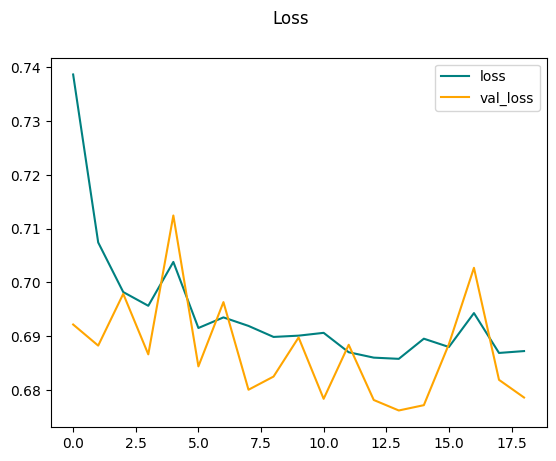

In [9]:
fig = plt.figure()
plt.plot(history.history['loss'], color = 'teal', label = 'loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss')
plt.legend(loc = "upper right")
plt.show()

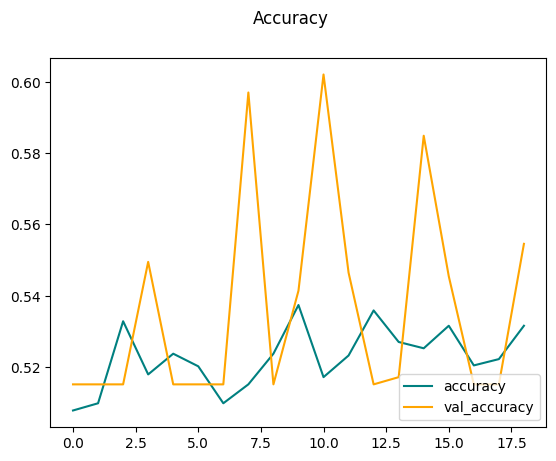

In [10]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()
f1score= F1Score(average='micro', threshold=0.5)
all_labels = []
all_predictions = []

for batch in test_generator:
    x, y = batch
    yhat = model.predict(x)
    y = np.expand_dims(y, axis=-1)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)
    f1score.update_state(y, yhat)

    all_labels.extend(y.flatten())
    all_predictions.extend(yhat.flatten())

print(f'Precision:{pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}, F1Score:{f1score.result().numpy()}')

all_predictions_classes = (np.array(all_predictions) > 0.5).astype(int)
all_labels_classes = (np.array(all_labels) > 0.5).astype(int)

cm = confusion_matrix(all_labels_classes, all_predictions_classes)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f'Specificity: {specificity}, Sensitivity (Recall): {sensitivity}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 34ms/step


In [ ]:
# Save the model in Keras format (HDF5)
model.save('/content/shoplifting_model.h5')
model.save('content/shoplifting_model.keras')